In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/rosemann/train.csv
/kaggle/input/rosemannstore/store.csv
/kaggle/input/rose-dataset/train.csv


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import prophet
from prophet import Prophet

In [4]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [5]:
import warnings
warnings.filterwarnings("ignore")

plt.style.use('ggplot')
plt.style.use('fivethirtyeight')

def mean_absolute_percentage_error(y_true, y_pred): 
    """Calculates MAPE given y_true and y_pred"""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [6]:
rose=pd.read_csv('/kaggle/input/rose-dataset/train.csv',
                  index_col=[0],
                  parse_dates=[0])
rose_store=pd.read_csv('/kaggle/input/rosemannstore/store.csv')
rose.head()


,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
Store,,,,,,,,
1,5,2015-07-31,5263,555,1,1,0,1
2,5,2015-07-31,6064,625,1,1,0,1
3,5,2015-07-31,8314,821,1,1,0,1
4,5,2015-07-31,13995,1498,1,1,0,1
5,5,2015-07-31,4822,559,1,1,0,1


In [7]:
rose['Date'] = pd.to_datetime(rose['Date'])

In [8]:
rose = rose[rose['Open'] == 1]

In [9]:
rose = rose[rose['Sales'] > 0]

In [10]:
df = rose.merge(rose_store, on='Store', how='left')

In [11]:
df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month
df['Week'] = df['Date'].dt.isocalendar().week
df['IsHoliday'] = df['StateHoliday'].apply(lambda x: 0 if x == '0' else 1)
df['DayOfWeek'] = df['Date'].dt.dayofweek
df['WeekdayName'] = df['Date'].dt.day_name()

In [12]:
df['PromoActive'] = df['Promo']
df['Promo2Active'] = df['Promo2']
df['IsStateHoliday'] = df['StateHoliday'].apply(lambda x: 0 if x == '0' else 1)
df['IsSchoolHoliday'] = df['SchoolHoliday']

In [13]:
df['CompetitionDistance'] = df['CompetitionDistance'].fillna(
    df['CompetitionDistance'].median()
)

In [14]:
%%time
monthly_df = (
    df.groupby('Date')
    .agg({
        'Sales':'sum',
        'PromoActive':'mean',
        'IsStateHoliday':'mean',
        'IsSchoolHoliday':'mean'
    })
    .reset_index()
)

CPU times: user 42.4 ms, sys: 3.92 ms, total: 46.4 ms
Wall time: 50.6 ms


In [15]:
monthly_df.rename(columns={
    'Date':'ds',
    'Sales':'y'
}, inplace=True)

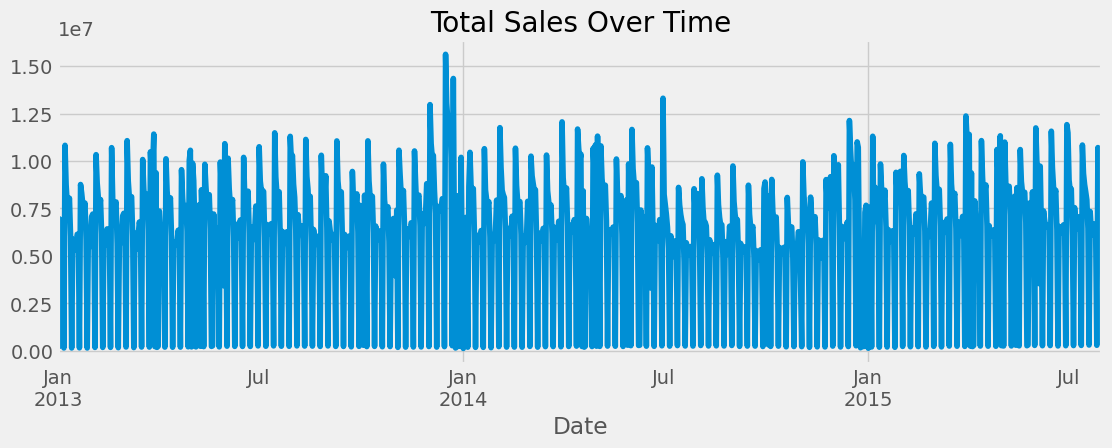

In [16]:
df.groupby('Date')['Sales'].sum().plot(figsize=(12,4))
plt.title("Total Sales Over Time")
plt.show()

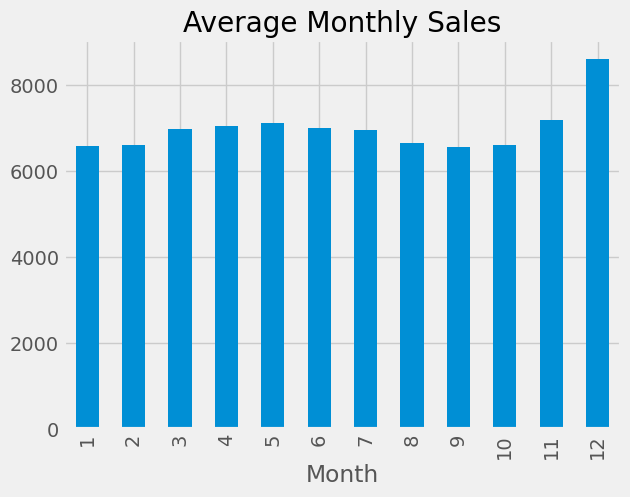

In [17]:
df.groupby('Month')['Sales'].mean().plot(kind='bar')
plt.title("Average Monthly Sales")
plt.show()

In [18]:
train_df = monthly_df.iloc[:-6]
val_df   = monthly_df.iloc[-6:]

In [19]:

model = Prophet(
    yearly_seasonality=True,
    weekly_seasonality=False,
    daily_seasonality=False,
    changepoint_prior_scale=0.1
)

model.fit(train_df)

19:15:09 - cmdstanpy - INFO - Chain [1] start processing
19:15:09 - cmdstanpy - INFO - Chain [1] done processing


In [20]:
future = model.make_future_dataframe(periods=6, freq='M')
forecast = model.predict(future)

In [21]:
y_true = val_df['y'].values
y_pred = forecast.iloc[-6:]['yhat'].values

In [22]:
mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
print(f"Validation MAPE: {mape:.2f}%")

Validation MAPE: 365.32%


In [23]:
comparison = pd.DataFrame({
    'Date': val_df['ds'],
    'Actual': y_true,
    'Predicted': y_pred
})

print(comparison)

          Date    Actual     Predicted
936 2015-07-26    285865  6.066724e+06
937 2015-07-27  10707292  5.859368e+06
938 2015-07-28   9115073  5.863681e+06
939 2015-07-29   8499962  6.013153e+06
940 2015-07-30   8798854  7.237832e+06
941 2015-07-31  10109742  5.887509e+06


In [24]:
monthly_df['y'] = np.log1p(monthly_df['y'])

In [26]:
train_df = monthly_df.iloc[:-6]
val_df   = monthly_df.iloc[-6:]

In [27]:
model = Prophet(yearly_seasonality=True)
model.fit(train_df)

19:19:13 - cmdstanpy - INFO - Chain [1] start processing
19:19:13 - cmdstanpy - INFO - Chain [1] done processing


In [28]:
future = model.make_future_dataframe(periods=6, freq='M')
forecast = model.predict(future)

In [29]:
y_true = np.expm1(val_df['y'].values)
y_pred = np.expm1(forecast.iloc[-6:]['yhat'].values)

In [30]:
mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
print(f"Validation MAPE after log transform: {mape:.2f}%")

Validation MAPE after log transform: 420.68%


In [31]:
def smape(y_true, y_pred):
    return np.mean(
        2 * np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred))
    ) * 100

smape_value = smape(y_true, y_pred)
print(f"Validation SMAPE: {smape_value:.2f}%")

Validation SMAPE: 62.74%


In [32]:
from sklearn.metrics import mean_absolute_error

mae = mean_absolute_error(y_true, y_pred)
print(f"Validation MAE: {mae:.2f}")

Validation MAE: 3639342.80


In [33]:
import holidays

india_holidays = holidays.India()

holiday_df = pd.DataFrame({
    'ds': pd.to_datetime(list(india_holidays.keys())),
    'holiday': list(india_holidays.values())
})

In [34]:
model = Prophet(
    yearly_seasonality=True,
    holidays=holiday_df
)
model.fit(train_df)


19:23:18 - cmdstanpy - INFO - Chain [1] start processing
19:23:18 - cmdstanpy - INFO - Chain [1] done processing


In [35]:
future = model.make_future_dataframe(periods=len(val_df), freq='M')
forecast = model.predict(future)

In [37]:
y_true = np.expm1(val_df['y'].values)
y_pred = np.expm1(forecast.iloc[-6:]['yhat'].values)

In [38]:
mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
print(f"Validation MAPE after log transform: {mape:.2f}%")

Validation MAPE after log transform: 420.68%


In [40]:
final_model = Prophet(
    yearly_seasonality=True,
    weekly_seasonality=False,
    daily_seasonality=False,
    changepoint_prior_scale=0.1
)

final_model.fit(monthly_df)

19:29:37 - cmdstanpy - INFO - Chain [1] start processing
19:29:37 - cmdstanpy - INFO - Chain [1] done processing


In [41]:
future_final = final_model.make_future_dataframe(periods=12, freq='M')
forecast_final = final_model.predict(future_final)


In [42]:
forecast_final[['ds','yhat','yhat_lower','yhat_upper']].to_csv(
    "forecast.csv", index=False
)

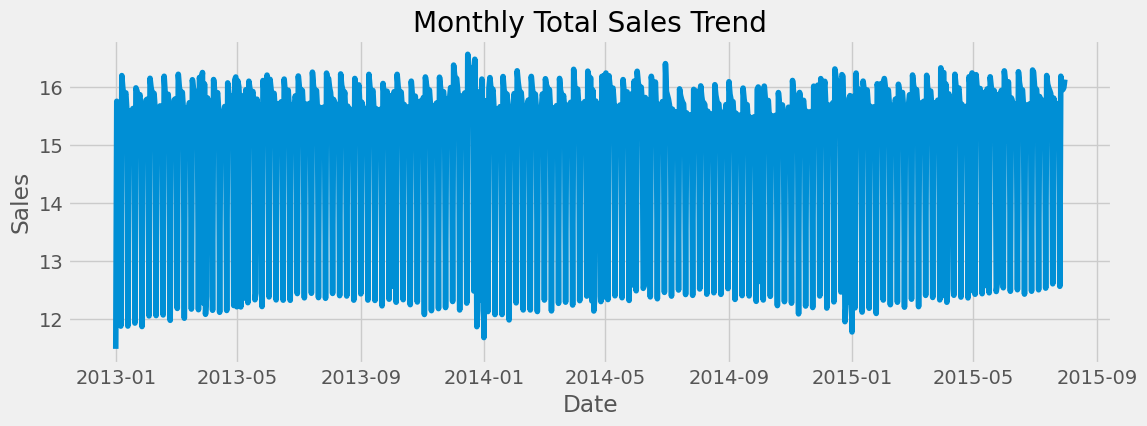

In [46]:
plt.figure(figsize=(12,4))
plt.plot(monthly_df['ds'], monthly_df['y'])
plt.title("Monthly Total Sales Trend")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.show()

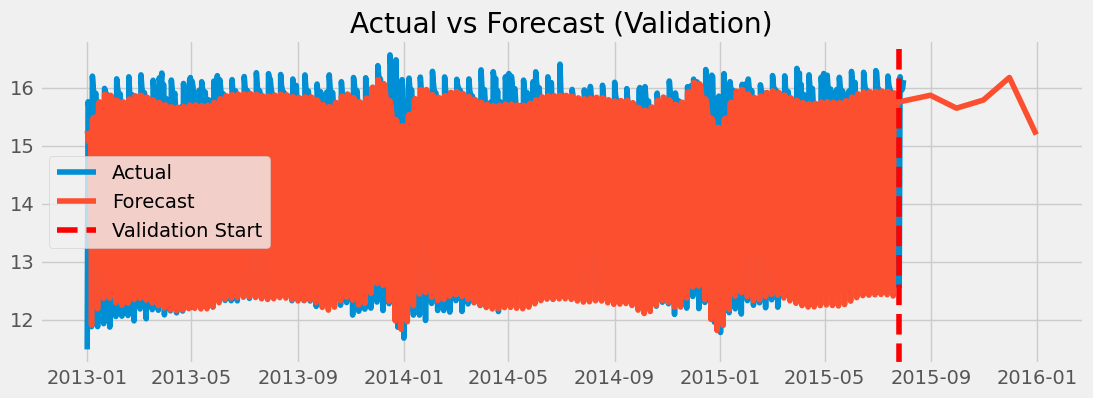

In [48]:
plt.figure(figsize=(12,4))
plt.plot(monthly_df['ds'], monthly_df['y'], label='Actual')
plt.plot(forecast['ds'], forecast['yhat'], label='Forecast')
plt.axvline(val_df['ds'].iloc[0], color='red', linestyle='--', label='Validation Start')
plt.legend()
plt.title("Actual vs Forecast (Validation)")
plt.show()


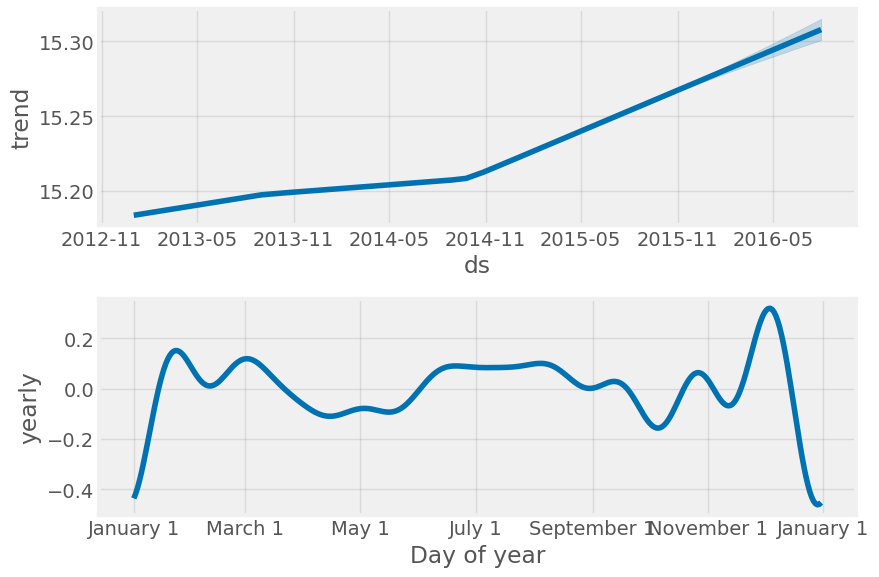

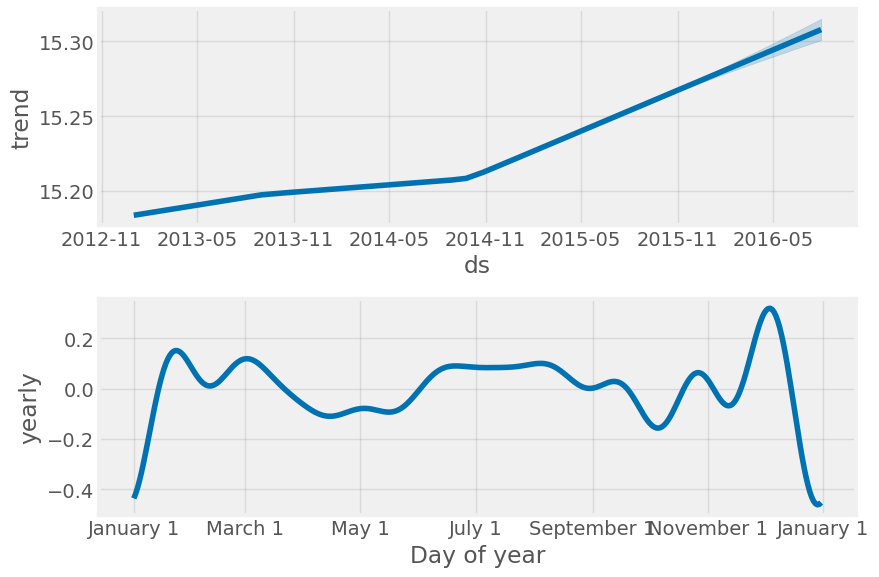

In [49]:
final_model.plot_components(forecast_final)

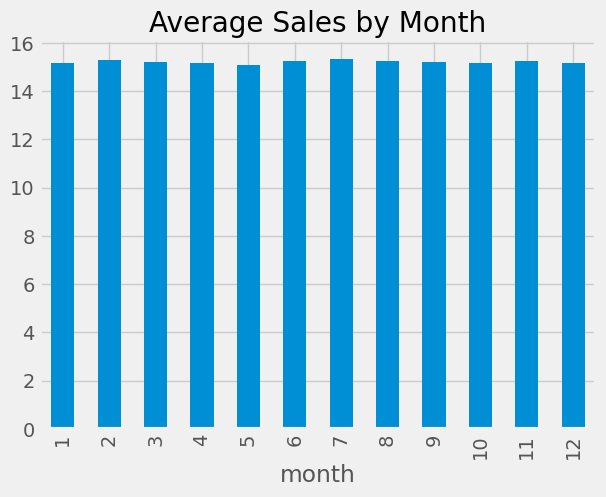

In [50]:
monthly_df['month'] = monthly_df['ds'].dt.month
monthly_df.groupby('month')['y'].mean().plot(kind='bar')
plt.title("Average Sales by Month")
plt.show()


In [53]:
actual = monthly_df['y']
predicted = forecast.loc[:len(actual)-1, 'yhat']

mape = mean_absolute_percentage_error(actual, predicted)
print("MAPE:", mape)

MAPE: 1.9790645933355642


In [54]:
def smape(y_true, y_pred):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    
    denominator = (np.abs(y_true) + np.abs(y_pred))
    
    # avoid division by zero
    mask = denominator != 0
    
    smape_value = np.mean(
        2 * np.abs(y_pred[mask] - y_true[mask]) / denominator[mask]
    ) * 100
    
    return smape_value

In [55]:
actual = val_df['y'].values
predicted = forecast.iloc[-len(val_df):]['yhat'].values

smape_value = smape(actual, predicted)
print(f"Validation SMAPE: {smape_value:.2f}%")

Validation SMAPE: 5.87%


In [56]:
print(val_df[['ds','y']])
print(forecast.iloc[-len(val_df):][['ds','yhat']])

            ds          y
936 2015-07-26  12.563278
937 2015-07-27  16.186436
938 2015-07-28  16.025440
939 2015-07-29  15.955572
940 2015-07-30  15.990132
941 2015-07-31  16.129010
            ds       yhat
936 2015-07-31  15.769448
937 2015-08-31  15.867636
938 2015-09-30  15.645039
939 2015-10-31  15.785112
940 2015-11-30  16.173414
941 2015-12-31  15.190059


In [57]:
final_df = forecast[['ds','yhat','yhat_lower','yhat_upper']]
final_df.to_csv("sales_forecast.csv", index=False)